## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [ ]:
link = 'http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222'
response = requests.get(link)
msg = response.text
parsed_document = BeautifulSoup(msg, features = 'html.parser')
comissions = parsed_document.find_all('a')[8:-4] #-4

urls = dict()
for com in comissions:
    urls[com.contents[0]] = 'http://notelections.online' + com.get('href')

data = []

for com, url in urls.items():
    request = requests.get(url)
    msg = request.text
    parsed_document = BeautifulSoup(msg, 'html.parser')
    tds = parsed_document.find_all('td')[20:]

    vals = [td.find_all('nobr')[0].contents[0] for td in tds[0:31:3]]
    candidates = [td.find_all('nobr')[0].contents[0] for td in tds[35:43:3]]
    
    idx = 44
    local_commisions_list = []
    while True:
        nobr = tds[idx].find_all('nobr')[0]
        a = nobr.find_all('a')
        if len(a) == 1:
            local_commisions_list.append(a[0].contents[0])
            idx += 1
        else:
            break
            
    lc_data = [{} for i in range(len(local_commisions_list))]
    for i in range(len(vals)):
        for j in range(len(local_commisions_list)):
            nobrs = tds[idx+j].find_all("nobr")[0].b
            lc_data[j][vals[i]] = int(nobrs.contents[0])
        idx += len(local_commisions_list)
    idx += 2
    
    candidates_data = [[0 for j in range(len(candidates))] for i in range(len(local_commisions_list))]
    for i in range(len(candidates)):
        for j in range(len(local_commisions_list)):
            nobrs = tds[idx + j].find_all("nobr")[0].b
            candidates_data[j][i] = int(nobrs.contents[0])
                
        idx += len(local_commisions_list)

    for i in range(len(local_commisions_list)):
        data.append({"ТИК №": com, "УИК №": local_commisions_list[i]})        
        data[-1].update({vals[j]: lc_data[i][vals[j]] for j in range(len(vals))})
        data[-1].update({candidates[j]: candidates_data[i][j] for j in range(len(candidates))})
        
df = pd.DataFrame(data)
df

In [ ]:
df.to_csv('data/elections.csv', index = False)

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [3]:
df = pd.read_csv('data/elections.csv')
import matplotlib.pyplot as plt 

In [4]:
df['Всего бюллетеней'] = df['Число недействительных избирательных бюллетеней'] + df['Число действительных избирательных бюллетеней']
df['Явка'] = df['Всего бюллетеней'] / df['Число избирательных бюллетеней, полученных участковой избирательной комиссией']
df['Явка'] *=100
df1 = df.sort_values("Явка", ascending=False, inplace=False)
df1

,ТИК №,УИК №,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Беглов Александр Дмитриевич,Тихонова Надежда Геннадьевна,Всего бюллетеней,Явка
146,Территориальная избирательная комиссия №2,УИК №2308,300,300,287,13,0,13,287,5,295,0,0,11,269,15,300,100.000000
1154,Территориальная избирательная комиссия №18,УИК №1665,183,183,122,61,0,61,122,4,179,0,0,18,129,32,183,100.000000
1267,Территориальная избирательная комиссия №20,УИК №1983,169,169,93,76,0,76,93,3,166,0,0,9,152,5,169,100.000000
1155,Территориальная избирательная комиссия №18,УИК №1667,128,126,7,119,0,119,7,1,125,0,0,17,91,17,126,100.000000
1142,Территориальная избирательная комиссия №18,УИК №1653,2539,1700,1639,55,6,55,1639,27,1667,0,0,154,1385,128,1694,99.647059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,Территориальная избирательная комиссия №26,УИК №1180,2026,2000,302,20,1678,20,301,12,309,0,0,53,180,76,321,16.050000
1537,Территориальная избирательная комиссия №23,УИК №2389,99,500,18,62,420,62,18,1,79,0,0,6,60,13,80,16.000000
2010,Территориальная избирательная комиссия №30,УИК №2272,63,500,31,28,441,28,31,3,56,0,0,10,37,9,59,11.800000
270,Территориальная избирательная комиссия №4,УИК №959,37,500,37,0,463,0,37,0,37,0,0,2,35,0,37,7.400000


In [5]:
name = 'Беглов Александр Дмитриевич'

candidates = ['Тихонова Надежда Геннадьевна', 'Беглов Александр Дмитриевич', 'Амосов Михаил Иванович']
for cand in candidates:
    df[f'{cand} %'] = df[f'{cand}'] / df['Всего бюллетеней'] * 100
    
df2 = df.sort_values(f'{name} %', ascending=False, inplace=False)
df2.loc[df['Всего бюллетеней'] >= 100]

,ТИК №,УИК №,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,...,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Беглов Александр Дмитриевич,Тихонова Надежда Геннадьевна,Всего бюллетеней,Явка,Тихонова Надежда Геннадьевна %,Беглов Александр Дмитриевич %,Амосов Михаил Иванович %
1395,Территориальная избирательная комиссия №22,УИК №343,3537,4000,3523,0,477,0,3523,0,...,0,0,23,3451,49,3523,88.075000,1.390860,97.956287,0.652853
1453,Территориальная избирательная комиссия №22,УИК №403,668,1000,68,600,332,600,68,3,...,0,0,6,652,7,668,66.800000,1.047904,97.604790,0.898204
1455,Территориальная избирательная комиссия №22,УИК №405,346,500,335,11,154,11,335,6,...,0,0,3,332,5,346,69.200000,1.445087,95.953757,0.867052
1376,Территориальная избирательная комиссия №21,УИК №894,2686,3000,2684,0,316,0,2684,0,...,0,0,62,2542,80,2684,89.466667,2.980626,94.709389,2.309985
787,Территориальная избирательная комиссия №11,УИК №2357,200,200,182,13,5,13,182,0,...,0,0,7,183,5,195,97.500000,2.564103,93.846154,3.589744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,Территориальная избирательная комиссия №29,УИК №2176,1538,1500,371,3,1126,3,371,8,...,0,0,103,141,122,374,24.933333,32.620321,37.700535,27.540107
1094,Территориальная избирательная комиссия №17,УИК №2283,2531,2000,641,3,1356,3,641,6,...,0,0,117,215,306,644,32.200000,47.515528,33.385093,18.167702
140,Территориальная избирательная комиссия №2,УИК №183,2017,1500,538,1,961,1,538,14,...,0,0,170,176,179,539,35.933333,33.209647,32.653061,31.539889
1090,Территориальная избирательная комиссия №17,УИК №572,3173,2500,856,6,1638,6,850,15,...,0,0,220,273,348,856,34.240000,40.654206,31.892523,25.700935


In [6]:
(df.groupby('ТИК №')['Явка'].max() - df.groupby('ТИК №')['Явка'].min()).sort_values(ascending=False)

ТИК №
Территориальная избирательная комиссия №23    82.333333
Территориальная избирательная комиссия №2     79.866667
Территориальная избирательная комиссия №30    78.600000
Территориальная избирательная комиссия №20    78.400000
Территориальная избирательная комиссия №26    75.100442
Территориальная избирательная комиссия №28    74.675000
Территориальная избирательная комиссия №11    74.060000
Территориальная избирательная комиссия №19    71.517007
Территориальная избирательная комиссия №7     70.502351
Территориальная избирательная комиссия №8     70.200000
Территориальная избирательная комиссия №27    69.885714
Территориальная избирательная комиссия №17    68.850000
Территориальная избирательная комиссия №1     66.761905
Территориальная избирательная комиссия №13    66.704762
Территориальная избирательная комиссия №21    66.516667
Территориальная избирательная комиссия №29    66.340000
Территориальная избирательная комиссия №22    65.475000
Территориальная избирательная комиссия №3 

In [7]:
df.groupby('ТИК №')['Явка'].var().sort_values(ascending=False)

ТИК №
Территориальная избирательная комиссия №13    353.619833
Территориальная избирательная комиссия №30    297.096630
Территориальная избирательная комиссия №18    293.280200
Территориальная избирательная комиссия №19    240.262439
Территориальная избирательная комиссия №2     206.476992
Территориальная избирательная комиссия №1     188.599340
Территориальная избирательная комиссия №28    181.428115
Территориальная избирательная комиссия №8     173.306419
Территориальная избирательная комиссия №23    163.317533
Территориальная избирательная комиссия №11    159.415243
Территориальная избирательная комиссия №20    158.273158
Территориальная избирательная комиссия №27    154.978420
Территориальная избирательная комиссия №21    148.539655
Территориальная избирательная комиссия №26    148.312762
Территориальная избирательная комиссия №9     147.539238
Территориальная избирательная комиссия №17    136.493583
Территориальная избирательная комиссия №15    135.879188
Территориальная избирател

In [8]:
df3 = []
for cand in candidates:
    df[f'{cand} %'] = np.round(df[f'{cand} %'])
    df3.append(pd.DataFrame(df.groupby(f'{cand} %').count()['УИК №']))
    df3[-1].columns = ['Кол-во УИК']

df3[1]

,Кол-во УИК
Беглов Александр Дмитриевич %,
30.0,1
32.0,1
33.0,2
38.0,3
39.0,3
...,...
93.0,1
94.0,3
95.0,2


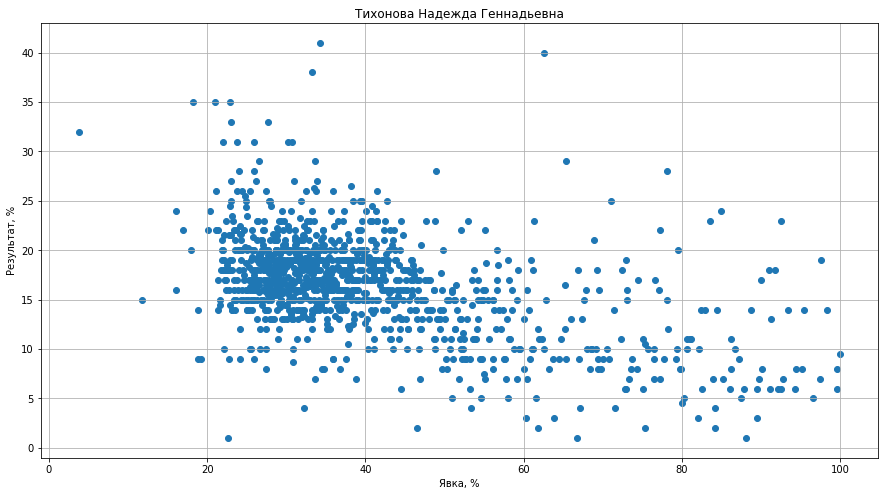

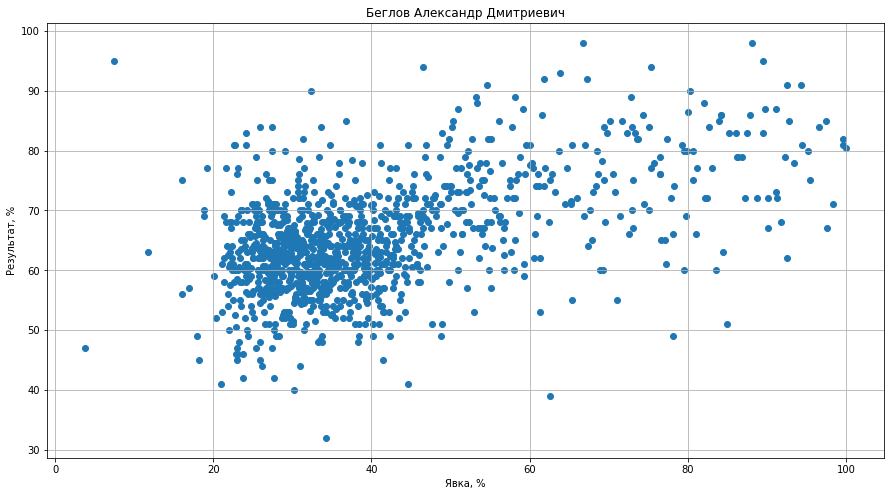

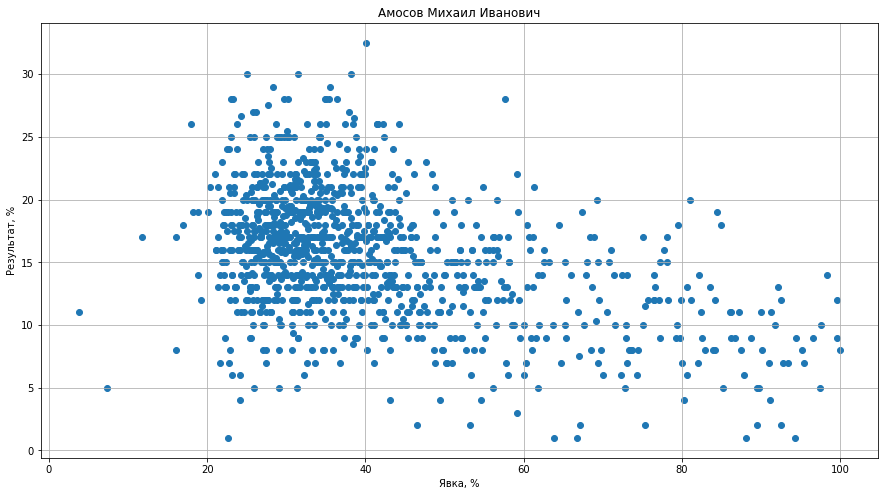

In [11]:
for name in candidates:
    coords = df.loc[df[f'{name} %'] != 0].groupby('Явка')[f'{name} %'].mean()

    x = coords.index
    y = coords.values

    plt.figure(figsize=(15, 8))
    plt.title(name)
    plt.scatter(x, y)
    plt.xlabel('Явка, %')
    plt.ylabel('Результат, %')
    plt.grid()
    plt.show()